<a href="https://colab.research.google.com/github/rayaneghilene/AutoEncoders/blob/main/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar xvzf /content/maps.tar.gz
!pip install pytorch-lightning


--2023-10-27 21:32:30--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  2.72MB/s    in 2m 22s  

2023-10-27 21:34:53 (1.68 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/53

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

# Generating Images

In recent studies, Groundbreaking research are done using diffusion models to generate images. However, previously other models were used to perform that task. Image Generation has multiple application in Industries (NFT Creation, Virtual Try Outs, Deep Fake Generation..)

Goal of this lab :
* Hands on Generative Models
* Solidify your knowledge in Deep Learning
* Use someone else's code
* Reuse Pytorch Lightning
* Have an Insight of industrial application of AI

## Back to the Basics : AutoEncoders

As you might remember in your 2nd year labs, we used an AutoEncoder to recreate some input images. In this part, we will reconstruct data from the MNIST Dataset.


### Lightning DataModule

We will reuse the datamodule used in the first lab. So just run the following cell.

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size = 32

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            mnist_train_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            self.train_size = int(0.8 * len(mnist_train_dataset))
            self.valid_size = len(mnist_train_dataset) - self.train_size
            self.mnist_train, self.mnist_valid =  torch.utils.data.random_split(mnist_train_dataset, [self.train_size, self.valid_size])
        # Second stage is 'test'
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_valid, self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.mnist_test,self.batch_size, shuffle=True)

### Lightning Module

#### AutoEncoder : Creating and Using a Latent Space

<img src="https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png">

Reminder : An AutoEncoder is composed of an Encoder and a Decoder. The Encoder creates a representation of the input datas, called latent space. The Decoder uses the latent space representation of the Input to reconstruct it.

We provide you with a code of an AutoEncoder class.
* **Using the given code, create an AutoEncoder composed of 3 stacks.**

In [4]:
import torch.nn as nn
import torch
class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvDown, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.out_channels,
                                            kernel_size = 3,
                                            stride = 1,
                                            padding = 0,
                                            dilation = 1),
                                  nn.BatchNorm2d(self.out_channels),
                                  nn.Dropout2d(0.5),
                                  nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class ConvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvUp, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.ConvTranspose2d(in_channels = self.in_channels,
                                      out_channels = self.out_channels,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 0,
                                      dilation = 1),
                    nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    channels = [in_channels]+ [2**i for i in range(3,10)]
    self.encoder = nn.ModuleList([ConvDown(channels[i], channels[i+1]) for i in range(number_of_stack)])

  def forward(self, x):
    for i, layer in enumerate(self.encoder):
      x = layer(x)
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels,number_of_stack ):
    super(Decoder, self).__init__()
    channels = [out_channels]+ [2**i for i in range(3,10)]
    self.decoder = nn.ModuleList([ConvUp(channels[i+1], channels[i]) for i in range(number_of_stack)])[::-1]

  def forward(self, x):
    for i, layer in enumerate(self.decoder):
      x = layer(x)
    return x

############################################## TODO ##############################################
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.encoder = Encoder(self.in_channels, number_of_stack)
    self.decoder = Decoder(self.in_channels, number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image

# TODO : Create a model composed of 3 stacks
model = AutoEncoder(in_channels =1 , number_of_stack = 3)



*   Create your Lightning Module



In [5]:
class AutoEncoderPL(pl.LightningModule):
    def __init__(self, in_channels, number_of_stack):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here.
        self.model = AutoEncoder(in_channels, number_of_stack)

    def forward(self,x):
        # TODO : Send the input through your model
        return self.model(x)

    def configure_optimizers(self):
        # Choose your optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


    def training_step(self, train_batch, batch_idx):
        # Define your Training Step
        # This method is pretty much similar to what your did in the first lab to train your model.
        x,_ = train_batch
        x_reconstructed = self(x)

        # x_reconstructed = nn.Flatten(x_reconstructed)
        loss = nn.functional.cross_entropy(x_reconstructed,x)
        # Don't remove the next line, you will understand why later
        self.log('train_loss', loss.item())
        return loss

    def validation_step(self, val_batch, batch_idx):
        # Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,_ = val_batch
        x_reconstructed = self(x)
        # x = nn.Flatten(x)
        # x_reconstructed = nn.Flatten(x_reconstructed)

        loss = nn.functional.cross_entropy(x_reconstructed,x)

        # Don't remove the next line, you will understand why later
        self.log('val_loss', loss.item())
        return loss

    def test_step(self, test_batch, batch_idx):
        # Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = test_batch
        x_reconstructed = self(x)

        loss = nn.functional.cross_entropy(x_reconstructed,x)
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss.item())
        return loss


    # TODO : Do we have to add some functions (test_epoch_start, test_epoch_end..) to compute a reconstruction metric ?


#### Training

##### Setting TensorBoard up

In [ ]:
# !kill 5106

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir "/content/tb_logs/my_model/version_0" --port 6040 # You might have to change the name of the folder, just look what folder were created on your Colab environment

##### Launch the Training

In [ ]:
# TODO :
# tb_logger = pl_loggers.TensorBoardLogger("Creating your own Model")


model = AutoEncoderPL(1,3)
dm = MNISTDataModule(32)
trainer = pl.Trainer(max_epochs=10,accelerator='cuda')
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 11.9 K
--------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


#### Testing

Test some images from the testing dataset to verify that your model works.

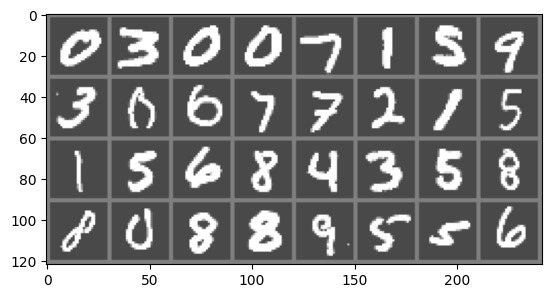

GroundTruth:      0     3     0     0


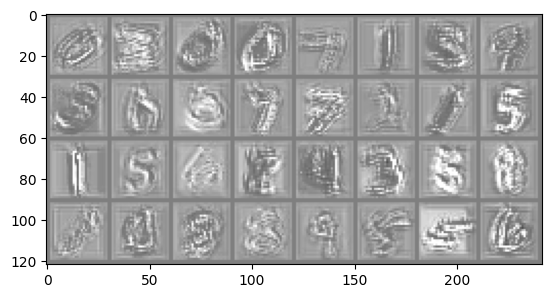

GroundTruth:      0     3     0     0


In [ ]:
# TODO : Plot some reconstructed images. Are they correct ?
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# functions to show an image (we coundn't import cv2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# test on random training images
dataiter = iter(test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))
outputs = model(images)

imshow(torchvision.utils.make_grid(outputs.detach()))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

### Going Further on AutoEncoders (Optional)

If you have some time, create other AutoEncoder with differnet latent sizes and train it.
* **What is the impact of the latent space toward the images reconstructions ?**

The model performs well when the latent space is bigger, when testing we noticed there's less loss of features

In the following code we tested using two stacks

In [ ]:
model = AutoEncoderPL(1,2)
dm = MNISTDataModule(32)
trainer = pl.Trainer(max_epochs=10,accelerator='cuda')
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 2.5 K 
--------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


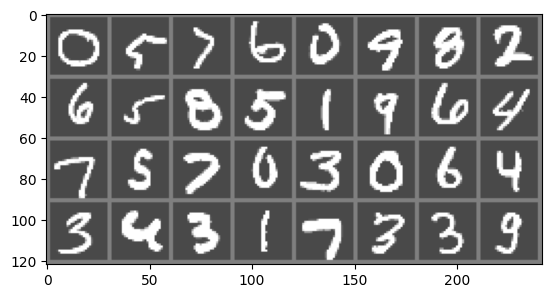

GroundTruth:      0     5     7     6


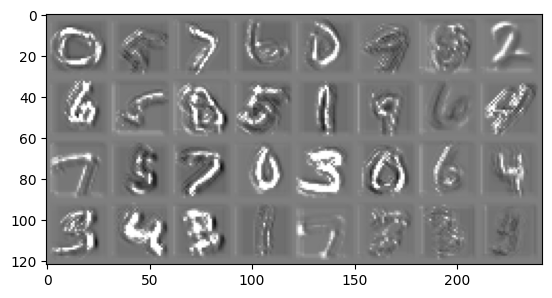

GroundTruth:      0     5     7     6


In [ ]:
# test on random training images
dataiter = iter(test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))
outputs = model(images)

imshow(torchvision.utils.make_grid(outputs.detach()))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

In the following code we tested using two stacks

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 48.9 K
--------------------------------------
48.9 K    Trainable params
0         Non-trainable params
48.9 K    Total params
0.196     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


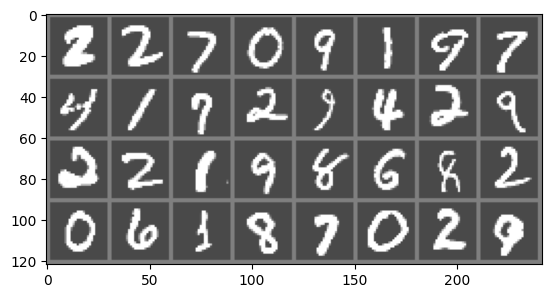

GroundTruth:      2     2     7     0


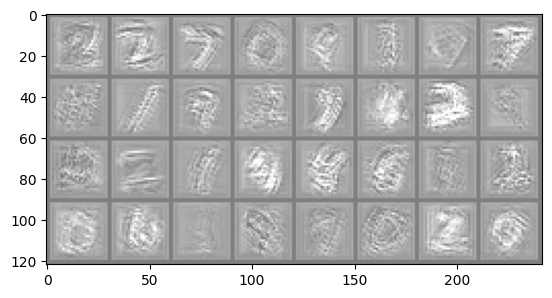

GroundTruth:      2     2     7     0


In [ ]:
model = AutoEncoderPL(1,4)
dm = MNISTDataModule(32)
trainer = pl.Trainer(max_epochs=10,accelerator='cuda')
trainer.fit(model, dm)
# test on random training images
dataiter = iter(test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))
outputs = model(images)

imshow(torchvision.utils.make_grid(outputs.detach()))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

## Industrial Application of GAN : Creating Google Maps Calque from Google Map Satellite view

Working on basic datasets is cool but as you are engineers to be, let's take it to industrial level. Given an image of a Google Map Satellite view, we want the model to predict a Calque view from it. This task is an Image translation task.

For example, using the image on the left, we want the model to predict the image on the right.
<img src="https://eu42.github.io/images/gcgan/aerial_image_map_example.png" height = 200>



In [ ]:
k1 =len(os.listdir('/content/maps/train'))
k2 =len(os.listdir('/content/maps/val'))

print("dataset conatins ", k1 + k2, "images")

dataset conatins  2194 images


### Lightning DataModule



#### Dataset

First, we need to write the Dataset. As usual, a custom Dataset class must implement three functions:
* __init__
* __len__
* __getitem__

Each image's shape is 1200x600x3. The satellite and the calque has the same size and are exactly half of the image

As the dataset doesn't have a proper test dataset, we will use the validation dataset as the test set. We will further create a validation dataset by taking a portion of the train dataset

In [6]:
from torchvision.transforms import ToPILImage

class GoogleDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.images = [path + i for i in os.listdir(path)]
    self.transform = transform

  def __getitem__(self,idx):
    image = self.images[idx]
    full_image = cv2.imread(image)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    h,w,c = full_image.shape
    # TODO : Retrieve the correct parts of the image.
    #split the full image in the middle the right part is the satellite image and the left part is the calque
    satellite = full_image[:,w//2:,:]
    calque = full_image[:,:w//2,:]

    if self.transform :
      satellite = ToPILImage()(satellite)
      calque = ToPILImage()(calque)

      # # Convert images to numpy arrays
      # satellite = np.array(satellite)
      # calque = np.array(calque)

      satellite = self.transform(satellite)
      calque = self.transform(calque)

    return {'satellite':satellite,
            'calque':calque}
  def __len__(self):
    return len(self.images)


#### Lightning DataModule

Now, let's prepare our DataModule.

In [7]:
from torchvision.transforms import Compose, Resize
class GoogleMapDataModule(pl.LightningDataModule):

    def __init__(self, batch_size):
        super().__init__()
        # TODO : In your Transformation, transform to Tensor and resize images to 128x128
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

        self.batch_size = batch_size
        # we are hardcoding the path are they won't change
        self.train_path = '/content/maps/train/'
        self.test_path = '/content/maps/val/'
    def prepare_data(self):
        GoogleDataset(self.train_path, self.transform)
        GoogleDataset(self.test_path, self.transform)
    def setup(self, stage):
        #First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            google_train = GoogleDataset(self.train_path, self.transform)
            train_size = int(0.7 * len(google_train ))
            test_size = len(google_train ) - train_size
            self.google_train, self.google_valid =  torch.utils.data.random_split(google_train , [train_size, test_size])
        #Second stage is 'test'
        if stage == "test" or stage is None:
            self.google_test = GoogleDataset(self.test_path, self.transform)
    def train_dataloader(self):
        return DataLoader(self.google_train, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.google_valid, batch_size=self.batch_size, shuffle=True)
    def test_dataloader(self):
      return DataLoader(self.google_test, batch_size=self.batch_size, shuffle=True)


### Lightning Module

* **Can we use an AutoEncoder to perform this task ?**


Let's use a much complex model. Generative Adversarial Networks.

#### Pix2Pix : cGAN

Instead of using a simple GAN, we will use a  conditional GAN (cGAN).

<img src='https://www.researchgate.net/profile/Gerasimos-Spanakis/publication/330474693/figure/fig1/AS:956606955139072@1605084279074/GAN-conditional-GAN-CGAN-and-auxiliary-classifier-GAN-ACGAN-architectures-where-x_Q320.jpg'>

 On the contrary of a normal GAN, cGAN has a condition that will help us CONTROL how the GAN should generate images. The generator will take some "inspiration" from the Condition. For example, if you want to generate digits from the MNIST Dataset, you can add a condition to force the GAN to create a specific Digit. In the MNIST case, the condition would be the class label.

Further details are in the following paper : https://arxiv.org/pdf/1411.1784.pdf



##### The Generator : Generating Images

In general, the Generator is here to generate Data from Noise. For example if we train a GAN on MNIST dataset, the generator will create digits using the noise we give it as input. In this lab, we are dealing with cGANs, so we need a Condition to condition our GAN.
* **What could be the condition in this task ?**

The condition can be an image/label

To answer that : the condition is a map image, we want to train our model to generate a map from a sattzlite image

* **What are we trying to do ?**

Generate images from random noise, classify them using a discriminator in a loop until the model is able to generate images that fit the conditions

* **What should the Generator do ? Should it recreate something specific ?**

the generator should generate white noise, the white noise should resemble the condition image (map in out case)

Let's use an AutoEncoder to perform the image translation.
* **Using previous classes, initialize your Generator using a 3 stack AutoEncoder.**

In [8]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, autoencoder, num_channels=1):
        super(Generator, self).__init__()
        self.autoencoder = autoencoder
        self.num_channels = num_channels

    def forward(self, z):
        # In the forward pass, we use the encoder of the autoencoder
        # to generate a latent representation 'z' and then decode it.
        latent_representation = self.autoencoder.encoder(z)
        reconstructed_image = self.autoencoder.decoder(latent_representation)
        return reconstructed_image

# Create a model composed of 3 stacks
model = Generator(autoencoder=AutoEncoder(in_channels=3, number_of_stack=3), num_channels=1)



##### The Discriminator : Forcing the Generator to predict better

The generator is able to create Images from Inputs, but we want the best quality possible. We need a model that would indicate to the Generator whether the generated Image are correct or not : the Discriminator.

The Discriminator is here to force the Generator to create better and better images. While the Generator creates bad quality generated image, the Discriminator will give a feedback.

<img src="https://i.imgflip.com/6y0kqe.jpg">

* **What could be the worst case scenario with the Generator and the Discriminator ?**

We provide you the code of a Discriminator that "works well".

In [9]:
class DiscriConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                  out_channels = out_channels,
                                  kernel_size = kernel_size,
                                  stride = 2,
                                  padding = 1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.LeakyReLU(0.2, inplace=True))
  def forward(self, x):
          return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            DiscriConv(in_channels, 32, 3),
            DiscriConv(32, 64, 4),
            DiscriConv(64, 128, 4),
            # 128x4x4
            nn.Conv2d(in_channels=128, out_channels=out_channels, kernel_size=3, bias=False)
        )

    def forward(self, input):
      return self.main(input)


##### The Loss : Adversarial Battle

<img src="https://miro.medium.com/max/1400/1*d96q6bCKbmZT9Ls7f3X6xg.jpeg">

This formula is the basic loss of the cGAN model. There are two terms, each optimizing specific.
Beautiful formula's no ? Let's understand them like humans.
* What is x, y, z in our Case ?


If we look at the formulas, there are two losses :
* What kind of losses are they ? Cross Entropies, Distance Losses ?
* Which term is the Discriminator loss ? Generator loss ?

The entire model will converge when the Generator provides the best fakes possible that the Discriminator won't be able to differentiate from the real images.

In [10]:
class GANLoss(nn.Module):
      def __init__(self, real_label=1, fake_label=0):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        # Initialization a binary label, if real label 1, if fake label 0
        self.real_label = real_label
        self.fake_label = fake_label

      def get_labels(self, predictions, real_or_not):
          # TODO : If we have a real data as input, we want its target label to be self.real_label. If we have fake data as input, we want its target lable to be self.fake_label
          # Fill in the ...
          labels = self.real_label if real_or_not else self.fake_label
          # return torch.tensor(labels).expand_as(predictions).to(predictions.device)
          return torch.full_like(predictions, labels, dtype=torch.float)
      def forward(self, predictions, real_or_not):
          # TODO : Return the Loss between the models prediction and the labels
          labels = self.get_labels(predictions, real_or_not)
          loss = self.loss(predictions, labels)
          return loss






##### The Final Module

Let's encompass everything under our Lightning Module. However, there are many steps to follow. In order to understand the code, read the commented parts.

In [11]:
class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Initialize your Generator and Discriminator
        self.autoencoder = AutoEncoder(in_channels=3, number_of_stack=3)
        self.generator = Generator(self.autoencoder, num_channels=3)
        self.discriminator = Discriminator(in_channels=2 * 3, out_channels=3)

        self.automatic_optimization = False
    def forward(self, satellite):
        img_fake = self.generator(satellite)
        return img_fake

    def training_step(self, train_batch, batch_idx):

        satellite, calque = train_batch['satellite'], train_batch['calque']
        criterion = GANLoss()
        criterionL1 = nn.L1Loss()

        # Get the optimizers
        opt_generators, opt_discriminators = self.optimizers()

        # Discriminator Training Part
        if self.trainer.current_epoch < 0.95 * self.trainer.max_epochs:
            # Goal: Train the Discriminator to differentiate fake and real data

            # Part 0: Train on Fake data
            fake_calque = self.generator(satellite)
            fake_data = torch.cat([satellite, fake_calque], dim=1)
            fake_prediction = self.discriminator(fake_data)
            loss_fake = criterion(fake_prediction, real_or_not=False)

            # Part 1: Train on Real data
            real_data = torch.cat([satellite, calque], dim=1)
            real_prediction = self.discriminator(real_data)
            loss_real = criterion(real_prediction, real_or_not=True)
            loss = (loss_real + loss_fake) / 2

            opt_discriminators.zero_grad()
            loss.backward()
            opt_discriminators.step()
            self.log('discriminator loss', loss)

        # Generator Training Part
        else:
            fake_calque = self.generator(satellite)
            fake_data = torch.cat([satellite, fake_calque], dim=1)
            fake_prediction = self.discriminator(fake_data)
            loss_true = criterion(fake_prediction, real_or_not=False)
            loss_l1 = criterionL1(fake_calque, calque) * 100
            generator_loss = loss_true + loss_l1

            opt_generators.zero_grad()
            generator_loss.backward()
            opt_generators.step()
            self.log('generator loss', generator_loss)

    def validation_step(self, val_batch, batch_idx):
      satellite, calque = val_batch['satellite'], val_batch['calque']
      criterion = GANLoss()
      criterionL1 = nn.L1Loss()
      # TODO : Send the Satellite Image through the Generator
      fake_calque = self.generator(satellite)
      # TODO : Compute the Loss between the fake calque and the real calque

      loss_l1 = criterionL1(fake_calque, calque)
      # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss

      fake_data = torch.cat([satellite, fake_calque], dim=1)
      fake_prediction = self.discriminator(fake_data)
      # TODO : Send the real calque, the satellite to the Discriminator,and compute the loss

      real_data = torch.cat([satellite, calque], dim=1)
      real_prediction = self.discriminator(real_data)

      # TODO : Don't forget to log the losses
      self.log('val_generator_loss', loss_l1)
      self.log('val_discriminator_loss_fake', criterion(fake_prediction, real_or_not=False))
      self.log('val_discriminator_loss_real', criterion(real_prediction, real_or_not=True))


    def test_step(self, test_batch, batch_idx):
      satellite, calque = test_batch['satellite'], test_batch['calque']
      criterion = GANLoss()
      criterionL1 = nn.L1Loss()
      # TODO : Send the Satellite Image through the Generator
      fake_calque = self.generator(satellite)
      # TODO : Compute the Loss between the fake calque and the real calque
      loss_l1 = criterionL1(fake_calque, calque)

      # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss
      fake_data = torch.cat([satellite, fake_calque], dim=1)
      fake_prediction = self.discriminator(fake_data)
      # TODO : Send the real calque, the satellite to the Discriminator,and compute the loss
      real_data = torch.cat([satellite, calque], dim=1)
      real_prediction = self.discriminator(real_data)
      # TODO : Don't forget to log the losses

      self.log('test_generator_loss', loss_l1)
      self.log('test_discriminator_loss_fake', criterion(fake_prediction, real_or_not=False))
      self.log('test_discriminator_loss_real', criterion(real_prediction, real_or_not=True))



    def configure_optimizers(self):
        optimizer_generator = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.005, 0.999))
        optimizer_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.005, 0.999))
        return [optimizer_generator, optimizer_discriminator], []



### Training

Train your model. We suggest you to train the model at least 10 epochs to see 'results'


In [31]:
datamodule = GoogleMapDataModule(32)
model = GAN()
trainer = pl.Trainer(max_epochs=20,accelerator='cuda')
trainer.fit(model, datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | autoencoder   | AutoEncoder   | 12.1 K
1 | generator     | Generator     | 12.1 K
2 | discriminator | Discriminator | 169 K 
------------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.727     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (24) is smaller than the logging interval Trainer(lo

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Testing

Test your model on few images of the test dataset. You can further try the model by cropping Satellite views from Google Maps

In [32]:
datamodule.setup(stage="test")
test = datamodule.test_dataloader()
trainer.test(model, dataloaders =test)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_discriminator_loss_fake │     0.048712167888879776     │
│ test_discriminator_loss_real │      2.906075954437256       │
│     test_generator_loss      │      0.1707172840833664      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_generator_loss': 0.1707172840833664,
  'test_discriminator_loss_fake': 0.048712167888879776,
  'test_discriminator_loss_real': 2.906075954437256}]

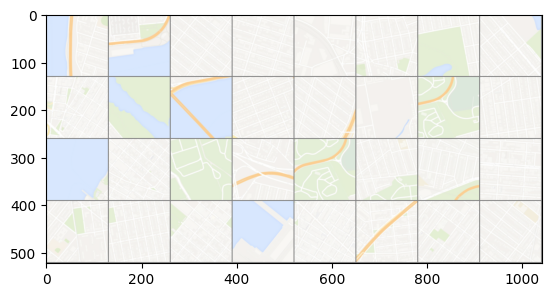

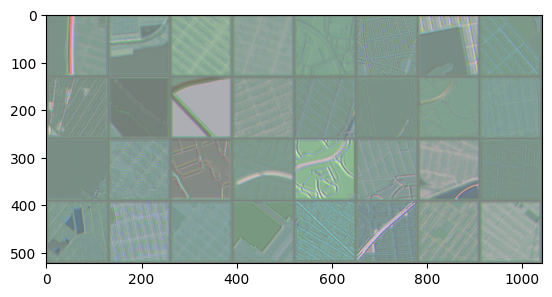

In [33]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images['satellite']))
outputs = model(images['satellite'])
# show images predicted
imshow(torchvision.utils.make_grid(outputs.detach()))

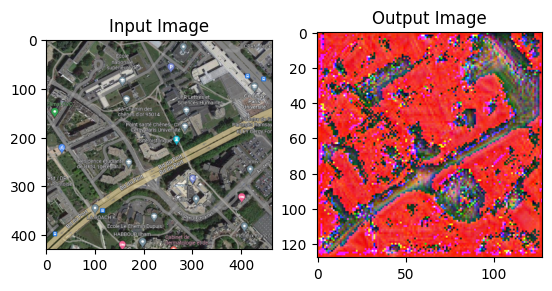

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# Load image as PIL Image
img_pil = Image.open('/content/img.png')
img_pil = img_pil.convert('RGB')
# Apply transform to image
img_tensor = datamodule.transform(img_pil)

# Add batch dimension to tensor
img_tensor = img_tensor.unsqueeze(0)


# Generate output image using model
output_tensor = model(img_tensor)

# Convert output tensor to PIL Image
output_pil = transforms.ToPILImage()(output_tensor.squeeze())

# Show input and output images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_pil)
axs[0].set_title('Input Image')
axs[1].imshow(output_pil)
axs[1].set_title('Output Image')
plt.show()